In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks, optimizers, metrics, Sequential
from tensorflow.keras import layers
import pickle
import yaml
from sklearn.ensemble import StackingClassifier

In [2]:
df = pd.read_csv('../data/processed/processed.csv')
train = pd.read_csv('../data/train/train.csv')
test = pd.read_csv('../data/test/test.csv')

In [3]:
X = df.drop(columns=['equipo_ganador'])
y = df['equipo_ganador']

In [4]:
X_train = train.drop(columns=['equipo_ganador'])
y_train = train['equipo_ganador']
X_test = test.drop(columns=['equipo_ganador'])
y_test = test['equipo_ganador']

## Standard Scaler

In [5]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)
X_scal = scaler.transform(X)

In [6]:
with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

## Logistic Regression

In [7]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scal, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Calculamos las predicciones y sus probabilidades

In [8]:
pred_proba_lr = lr.predict_proba(X_test_scal)[:,1]
pred_lr = lr.predict(X_test_scal)
print(pred_proba_lr)
print(pred_lr)

[0.73046556 0.73172318 0.16751657 ... 0.17954775 0.23143923 0.1185535 ]
[1 1 0 ... 0 0 0]


In [9]:
print('confusion_matrix: ', confusion_matrix(y_test, pred_lr))
print('accuracy_score: ', accuracy_score(y_test, pred_lr))
print('precision_score: ', precision_score(y_test, pred_lr))
print('recall_score: ', recall_score(y_test, pred_lr))
print('f1_score: ', f1_score(y_test, pred_lr))
print('roc_auc_score: ', roc_auc_score(y_test, pred_proba_lr))

confusion_matrix:  [[713 273]
 [246 744]]
accuracy_score:  0.7373481781376519
precision_score:  0.7315634218289085
recall_score:  0.7515151515151515
f1_score:  0.7414050822122571
roc_auc_score:  0.8161903005716393


In [10]:
with open("../models/logistic_regression.pkl", "wb") as f:
    pickle.dump(lr, f)

## Gradient Boosting Classifier

In [11]:
gb_clf = GradientBoostingClassifier()

In [12]:
param_gb_clf = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4]
}

grid_gb_clf = GridSearchCV(
    gb_clf,
    param_gb_clf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_gb_clf.fit(X_train_scal, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,GradientBoostingClassifier()
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [2, 3, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [13]:
print(grid_gb_clf.best_params_)
print(grid_gb_clf.best_score_)

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}
0.7947027428870569


In [14]:
gb_clf.fit(X_train_scal, y_train)
pred_proba_gbclf = gb_clf.predict_proba(X_test_scal)[:,1]
pred_gbclf = gb_clf.predict_proba(X_test_scal)

In [15]:
grid_proba_clf = grid_gb_clf.predict(X_test_scal)
grid_pred_proba_clf = gb_clf.predict_proba(X_test_scal)[:,1]

In [16]:
print('confusion_matrix: ', confusion_matrix(y_test, grid_proba_clf))
print('accuracy_score: ', accuracy_score(y_test, grid_proba_clf))
print('precision_score: ', precision_score(y_test, grid_proba_clf))
print('recall_score: ', recall_score(y_test, grid_proba_clf))
print('f1_score: ', f1_score(y_test, grid_proba_clf))
print('roc_auc_score: ', roc_auc_score(y_test, grid_pred_proba_clf))

confusion_matrix:  [[727 259]
 [267 723]]
accuracy_score:  0.7338056680161943
precision_score:  0.7362525458248472
recall_score:  0.7303030303030303
f1_score:  0.7332657200811359
roc_auc_score:  0.8142028807343209


In [17]:
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=200)
gb.fit(X_train_scal, y_train)
with open("../models/gradient_boosting.pkl", "wb") as f:
    pickle.dump(gb, f)

## Random Forest Classifier

In [18]:
rf = RandomForestClassifier()

param_dist = {
    "n_estimators": randint(300, 500),
    "max_depth": list(range(5, 20)),
}

rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=4,
    scoring="roc_auc",
    verbose=2,
    random_state=42
)

rand_rf.fit(X_train_scal, y_train)

print(rand_rf.best_params_)
print(rand_rf.best_score_)


Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV] END .....................max_depth=11, n_estimators=479; total time=   1.8s
[CV] END .....................max_depth=11, n_estimators=479; total time=   1.9s
[CV] END .....................max_depth=11, n_estimators=479; total time=   1.9s
[CV] END .....................max_depth=11, n_estimators=479; total time=   1.7s
[CV] END .....................max_depth=17, n_estimators=314; total time=   1.5s
[CV] END .....................max_depth=17, n_estimators=314; total time=   1.5s
[CV] END .....................max_depth=17, n_estimators=314; total time=   1.5s
[CV] END .....................max_depth=17, n_estimators=314; total time=   1.4s
[CV] END .....................max_depth=15, n_estimators=371; total time=   1.6s
[CV] END .....................max_depth=15, n_estimators=371; total time=   1.6s
[CV] END .....................max_depth=15, n_estimators=371; total time=   1.6s
[CV] END .....................max_depth=15, n_e

In [19]:
pred_rf = rand_rf.predict(X_test_scal)
pred_proba_rf = rand_rf.predict_proba(X_test_scal)[:,1]

In [20]:
print('confusion_matrix: ', confusion_matrix(y_test, pred_rf))
print('accuracy_score: ', accuracy_score(y_test, pred_rf))
print('precision_score: ', precision_score(y_test, pred_rf))
print('recall_score: ', recall_score(y_test, pred_rf))
print('f1_score: ', f1_score(y_test, pred_rf))
print('roc_auc_score: ', roc_auc_score(y_test, pred_proba_rf))

confusion_matrix:  [[724 262]
 [252 738]]
accuracy_score:  0.7398785425101214
precision_score:  0.738
recall_score:  0.7454545454545455
f1_score:  0.7417085427135678
roc_auc_score:  0.8140645809002807


In [21]:
rf = RandomForestClassifier(max_depth=6, n_estimators=431)
rf.fit(X_train_scal, y_train)
with open("../models/random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)

## ADA

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

base = DecisionTreeClassifier()

ada = AdaBoostClassifier(estimator=base)

param_dist = {
    "n_estimators": randint(50, 500),
    "learning_rate": uniform(0.01, 1.0),
    "estimator__max_depth": randint(1, 5),
    "estimator__min_samples_split": randint(2, 20),
}

rand_ada = RandomizedSearchCV(
    ada,
    param_distributions=param_dist,
    n_iter=60,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rand_ada.fit(X_train_scal, y_train)

print(rand_ada.best_params_)
print(rand_ada.best_score_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'estimator__max_depth': 2, 'estimator__min_samples_split': 2, 'learning_rate': np.float64(0.07355835028602363), 'n_estimators': 456}
0.7947023630822365


In [23]:
pred_ada = rand_ada.predict(X_test_scal)
pred_proba_ada = rand_ada.predict_proba(X_test_scal)[:,1]

In [24]:
print('confusion_matrix: ', confusion_matrix(y_test, pred_ada))
print('accuracy_score: ', accuracy_score(y_test, pred_ada))
print('precision_score: ', precision_score(y_test, pred_ada))
print('recall_score: ', recall_score(y_test, pred_ada))
print('f1_score: ', f1_score(y_test, pred_ada))
print('roc_auc_score: ', roc_auc_score(y_test, pred_proba_ada))

confusion_matrix:  [[722 264]
 [257 733]]
accuracy_score:  0.736336032388664
precision_score:  0.7352056168505516
recall_score:  0.7404040404040404


f1_score:  0.7377956718671363
roc_auc_score:  0.813934988833569


In [25]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, min_samples_split=2),
    n_estimators=456,
    learning_rate=0.07355835028602363
)

ada.fit(X_train_scal, y_train)
with open("../models/adaboost.pkl", "wb") as f:
    pickle.dump(ada, f)

## XGBoost

In [26]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    scale_pos_weight=1,
    random_state=42
)

param_grid = {
    "n_estimators": [150,300,500],
    "max_depth": [3, 5],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.7, 0.8],
}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train_scal, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.8], 'learning_rate': [0.03, 0.05], 'max_depth': [3, 5], 'n_estimators': [150, 300, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [27]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
0.7950214020194334


In [28]:
pred_xgb = grid_xgb.predict(X_test_scal)
pred_proba_xgb = grid_xgb.predict_proba(X_test_scal)[:,1]

In [29]:
print('confusion_matrix: ', confusion_matrix(y_test, pred_xgb))
print('accuracy_score: ', accuracy_score(y_test, pred_xgb))
print('precision_score: ', precision_score(y_test, pred_xgb))
print('recall_score: ', recall_score(y_test, pred_xgb))
print('f1_score: ', f1_score(y_test, pred_xgb))
print('roc_auc_score: ', roc_auc_score(y_test, pred_proba_xgb))

confusion_matrix:  [[713 273]
 [254 736]]
accuracy_score:  0.7332995951417004
precision_score:  0.7294350842418236
recall_score:  0.7434343434343434
f1_score:  0.7363681840920461
roc_auc_score:  0.8137664679246829


In [30]:
xgb = XGBClassifier(
    colsample_bytree=0.8, learning_rate=0.05,
    max_depth=3, n_estimators=150,
    subsample=0.8
)
xgb.fit(X_train_scal, y_train)
with open("../models/xgboost.pkl", "wb") as f:
    pickle.dump(xgb, f)

## KNN

In [31]:
knn = KNeighborsClassifier()

In [32]:
param_grid_knn = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "p": [1, 2]
}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring="roc_auc"
)

grid_knn.fit(X_train_scal, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan', ...], 'n_neighbors': [1, 3, ...], 'p': [1, 2], 'weights': ['uniform', 'distance']}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,21


In [33]:
print("Mejores hiperparámetros:", grid_knn.best_params_)
print("Mejor score CV:", grid_knn.best_score_)

Mejores hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}
Mejor score CV: 0.7756339118019273


In [34]:
pred_knn = grid_knn.predict(X_test_scal)
pred_proba_knn = grid_knn.predict_proba(X_test_scal)[:,1]

In [35]:
print('confusion_matrix: ', confusion_matrix(y_test, pred_knn))
print('accuracy_score: ', accuracy_score(y_test, pred_knn))
print('precision_score: ', precision_score(y_test, pred_knn))
print('recall_score: ', recall_score(y_test, pred_knn))
print('f1_score: ', f1_score(y_test, pred_knn))
print('roc_auc_score: ', roc_auc_score(y_test, pred_proba_knn))

confusion_matrix:  [[706 280]
 [281 709]]
accuracy_score:  0.7160931174089069
precision_score:  0.7168857431749242
recall_score:  0.7161616161616161
f1_score:  0.7165234967155129
roc_auc_score:  0.7935900588030406


In [36]:
knn= KNeighborsClassifier(metric='manhattan',n_neighbors=21,p=1,weights='uniform')
knn.fit(X_train_scal, y_train)
with open("../models/knn.pkl", "wb") as f:
    pickle.dump(knn, f)

## SVC

In [37]:
svc = SVC(probability=True)

In [38]:
param_grid_svc = {
    "C": [ 100,200],
    "kernel": ["rbf", 'poly'],
    "gamma": [0.01, 0.001],
    "degree": [2, 3, 4]
}

grid_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid_svc.fit(X_train_scal, y_train)

,estimator,SVC(probability=True)
,param_grid,"{'C': [100, 200], 'degree': [2, 3, ...], 'gamma': [0.01, 0.001], 'kernel': ['rbf', 'poly']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,100


In [39]:
print("Mejores parámetros:", grid_svc.best_params_)
print("Mejor score CV:", grid_svc.best_score_)

Mejores parámetros: {'C': 100, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}
Mejor score CV: 0.7964060291108108


In [40]:
pred_svc = grid_svc.predict(X_test_scal)
pred_proba_svc = grid_svc.predict_proba(X_test_scal)[:,1]

In [41]:
print('confusion_matrix: ', confusion_matrix(y_test, pred_svc))
print('accuracy_score: ', accuracy_score(y_test, pred_svc))
print('precision_score: ', precision_score(y_test, pred_svc))
print('recall_score: ', recall_score(y_test, pred_svc))
print('f1_score: ', f1_score(y_test, pred_svc))
print('roc_auc_score: ', roc_auc_score(y_test, pred_proba_svc))

confusion_matrix:  [[711 275]
 [249 741]]
accuracy_score:  0.7348178137651822
precision_score:  0.7293307086614174
recall_score:  0.7484848484848485
f1_score:  0.7387836490528414
roc_auc_score:  0.8161559817239331


In [42]:
svc = SVC(C=100, gamma=0.001, kernel="rbf", degree= 2,probability=True)
svc.fit(X_train_scal, y_train)
with open("../models/svc.pkl", "wb") as f:
    pickle.dump(svc, f)

## KMEANS

In [43]:
kmeans = KMeans(n_clusters=2, n_init=10)

pred_kmeans = kmeans.fit_predict(X_scal)

In [44]:
np.sum(pred_kmeans==y) / len(pred_kmeans)

np.float64(0.2844417451159024)

In [45]:
confusion_matrix(pred_kmeans, y)

array([[1410, 3549],
       [3520, 1400]])

In [46]:
with open("../models/kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)

## Keras Sequential

In [47]:
mod_seq = keras.Sequential([
    keras.Input(shape=(X_train_scal.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

mod_seq.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc_roc")]
)


In [48]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_auc_roc",
    patience=10,
    mode="max",
    restore_best_weights=True
)

history = mod_seq.fit(
    X_train_scal,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_roc: 0.7623 - loss: 0.5814 - val_auc_roc: 0.8023 - val_loss: 0.5393
Epoch 2/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_roc: 0.7915 - loss: 0.5506 - val_auc_roc: 0.8045 - val_loss: 0.5375
Epoch 3/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_roc: 0.7940 - loss: 0.5479 - val_auc_roc: 0.8029 - val_loss: 0.5381
Epoch 4/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_roc: 0.7956 - loss: 0.5460 - val_auc_roc: 0.8028 - val_loss: 0.5386
Epoch 5/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_roc: 0.7969 - loss: 0.5445 - val_auc_roc: 0.8017 - val_loss: 0.5390
Epoch 6/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_roc: 0.7976 - loss: 0.5438 - val_auc_roc: 0.8017 - val_loss: 0.5392
Epoch 7/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_roc: 0.7985 - loss: 0.5427 - val_auc_roc: 0.8013 - val_loss: 0.5389
Epoch 8/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_roc: 0.7993 - loss: 0.5420 - val_auc_roc: 0.8001 - v

In [49]:
test_loss, test_auc = mod_seq.evaluate(
    X_test_scal,
    y_test,
    verbose=0
)

print(f"AUC ROC en test: {test_auc:.4f}")


AUC ROC en test: 0.8127


In [50]:
mod_seq.evaluate(X_test_scal, y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_roc: 0.8127 - loss: 0.5280


[0.5280200242996216, 0.8126770257949829]

In [51]:
test_loss, test_auc = mod_seq.evaluate(X_test_scal, y_test, verbose=0)
print(f"Loss test: {test_loss:.4f}")
print(f"AUC-ROC test: {test_auc:.4f}")

Loss test: 0.5280
AUC-ROC test: 0.8127


In [52]:
pred_proba_mod_seq = mod_seq.predict(X_test_scal).ravel()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [53]:
mod_seq.save("../models/sequential_model.keras")

## Stacking Classifier

In [54]:
stack = StackingClassifier(
    estimators=[
        ("lr", lr),
        ("svc", svc),
        ("xgb", xgb)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)


In [55]:
stack.fit(X_train_scal, y_train)

,estimators,"[('lr', ...), ('svc', ...), ...]"
,final_estimator,LogisticRegression()
,cv,5
,stack_method,'auto'
,n_jobs,-1
,passthrough,False
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [56]:
pred_stack = stack.predict(X_test_scal)
pred_proba_stack = stack.predict_proba(X_test_scal)[:, 1]

In [57]:
print('confusion_matrix: ', confusion_matrix(y_test, pred_stack))
print('accuracy_score: ', accuracy_score(y_test, pred_stack))
print('precision_score: ', precision_score(y_test, pred_stack))
print('recall_score: ', recall_score(y_test, pred_stack))
print('f1_score: ', f1_score(y_test, pred_stack))
print('roc_auc_score: ', roc_auc_score(y_test, pred_proba_stack))

confusion_matrix:  [[713 273]
 [248 742]]
accuracy_score:  0.736336032388664
precision_score:  0.7310344827586207
recall_score:  0.7494949494949495
f1_score:  0.7401496259351621
roc_auc_score:  0.8160776118179769


In [ ]:
with open("../models/final_model_stacking.pkl", "wb") as f:
    pickle.dump(stack, f)

# Elección de modelo

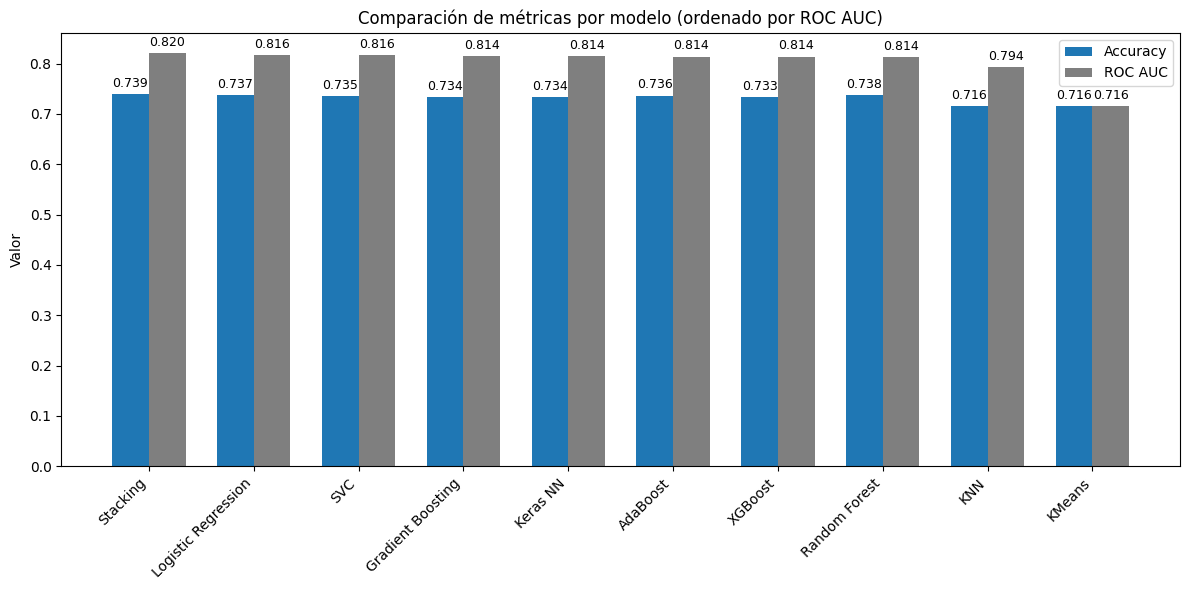

In [62]:

data = {
    "modelo": [
        "Logistic Regression", "Gradient Boosting", "Random Forest",
        "AdaBoost", "XGBoost", "KNN", "SVC", "KMeans", "Keras NN", "Stacking"
    ],
    "accuracy": [
        0.7373, 0.7338, 0.7378, 0.7363, 0.7333,
        0.7160, 0.7348, 0.7163, 0.7340, 0.7390
    ],
    "roc_auc": [
        0.8161, 0.8144, 0.8136, 0.8139, 0.8138,
        0.7936, 0.8161, 0.7163, 0.8141, 0.8200
    ]
}

df_plot = pd.DataFrame(data)


df_plot = df_plot.sort_values(by="roc_auc", ascending=False).reset_index(drop=True)

x = np.arange(len(df_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))


colors_accuracy = ["#1f77b4"]*len(df_plot)
colors_roc_auc = ["#7f7f7f"]*len(df_plot)


rects1 = ax.bar(x - width/2, df_plot["accuracy"], width, label='Accuracy', color=colors_accuracy)
rects2 = ax.bar(x + width/2, df_plot["roc_auc"], width, label='ROC AUC', color=colors_roc_auc)

ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas por modelo (ordenado por ROC AUC)')
ax.set_xticks(x)
ax.set_xticklabels(df_plot["modelo"], rotation=45, ha='right')
ax.legend()


for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [58]:
nombres_variables = X_train.columns

# Coeficientes del modelo
coeficientes = lr.coef_[0]

# Crear DataFrame
df_coef = pd.DataFrame({
    "Variable": nombres_variables,
    "Coeficiente": coeficientes
}).sort_values(by="Coeficiente", ascending=False)

df_coef


,Variable,Coeficiente
0,equipo_primera_sangre,0.071086
2,asistencias_dif,-0.001007
7,heraldos_dif,-0.062679
5,torretas_dif,-0.089681
4,minions_dif,-0.207648
6,dragones_dif,-0.264637
3,nivel_dif,-0.468846
1,asesinatos_dif,-0.726330


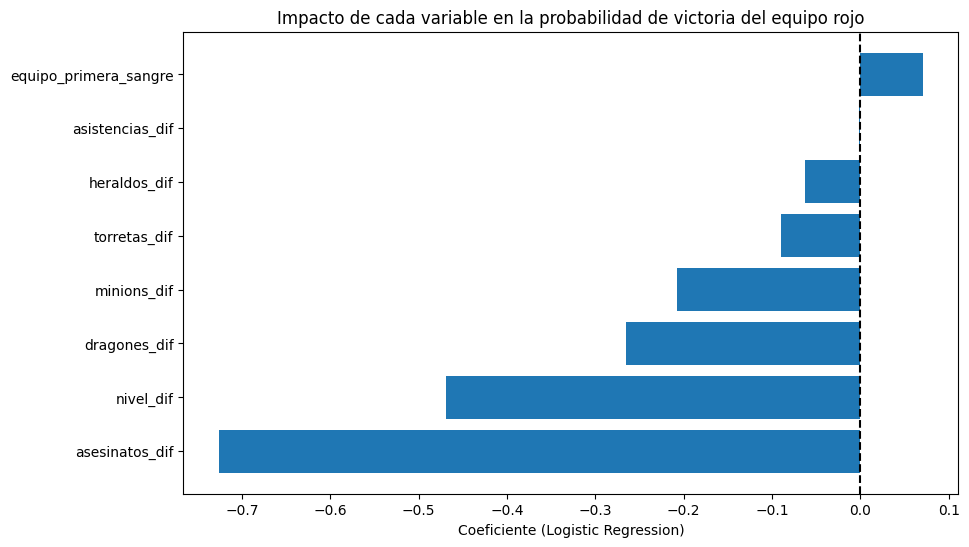

In [59]:
top_n = 10
df_plot = pd.concat([
    df_coef.head(top_n),
    df_coef.tail(top_n)
])

plt.figure(figsize=(10, 6))
plt.barh(df_plot["Variable"], df_plot["Coeficiente"])
plt.axvline(0, linestyle="--", color="black")
plt.xlabel("Coeficiente (Logistic Regression)")
plt.title("Impacto de cada variable en la probabilidad de victoria del equipo rojo")
plt.gca().invert_yaxis()
plt.show()

## Producto de negocio

In [61]:
while True:
    lado = input("¿En qué lado estás? (a = azul, r = rojo): ").strip().lower()
    if lado in ["a", "r"]:
        break
    print("Entrada no válida. Debes poner 'a' para azul o 'r' para rojo.")


snapshot_10min = X_test_scal[1].reshape(1, -1)


prob_rojo_gana = stack.predict_proba(snapshot_10min)[:, 1][0]


if lado == "a":
    prob_mi_equipo_gana = 1 - prob_rojo_gana 
else: 
    prob_mi_equipo_gana = prob_rojo_gana


umbral_alerta = 0.2
umbral_seguro = 0.7


if prob_mi_equipo_gana < umbral_alerta:
    estado = "⚠️ Alta probabilidad de perder"
elif prob_mi_equipo_gana > umbral_seguro:
    estado = "✅ Probabilidad de ganar alta"
else:
    estado = "🔹 Probabilidad intermedia"


print(f"Minuto 10 - Probabilidad de victoria para tu equipo: {prob_mi_equipo_gana:.2f}")
print(f"Estado: {estado}")


Minuto 10 - Probabilidad de victoria para tu equipo: 0.26
Estado: 🔹 Probabilidad intermedia
